In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections
import matplotlib.patches as mpatches

from utils import TimeWindow, TripInterval, TripStats, construct_trip
from tsp import smart_trip

### Create Warehouse Time Windows and Drive Times

TimeWindow(start, end), defined order of first destination to last. Each time is measured in hours since time=0.

In [32]:
WINDOWS = (TimeWindow(10, 15), # start
           TimeWindow(3, 18),
           TimeWindow(10, 18),
           TimeWindow(15, 35),
           TimeWindow(40, 45),
           TimeWindow(75, 100),
           TimeWindow(75, 100)) # end

Travel times between destinations.

In [33]:
travel_times = (6,2,4,10,10,15)

Create TripStats object.

In [34]:
TS = TripStats(WINDOWS, travel_times)

Execute SmartTrip algorithm.

In [35]:
results = smart_trip(TS)

In [36]:
print("Is this schedule possible? {}".format(results[0]))
TS = results[1]

Is this schedule possible? True


In [37]:
legs = construct_trip(TS)
legs_df = pd.DataFrame(legs[1], columns = ['type', 'end', 'start', 'last_stop'])

Get arrival and departure times.

In [38]:
report = TS.get_report()[['t_a', 't_d']].copy()
report.columns = ['depart', 'arrive']
report

,depart,arrive
6,100.0,100.0
5,75.0,75.0
4,55.0,45.0
3,35.0,35.0
2,21.0,18.0
1,16.0,16.0
0,10.0,10.0


## Plot Journey
Journey starts from top to bottom.

In [39]:
# compute total rest time between stop last_stop and last_stop - 1
def compute_rest_times(legs, last_stop):
    temp = legs.loc[(legs['type'] == 'rest') & (legs['last_stop'] == last_stop), :]
    temp = temp['start'] - temp['end']
    return temp.sum()  
    
# compute slope of rest time segment
def compute_slope(p0, p1, rest_time):
        return (p1[1] - p0[1])/(p1[0] - rest_time - p0[0])

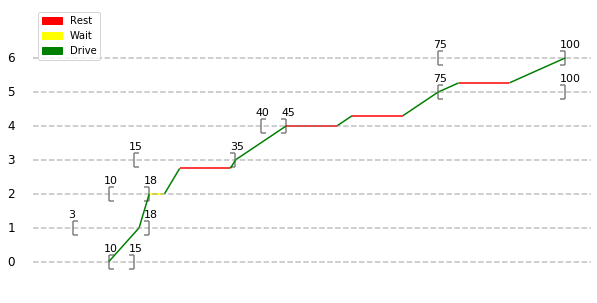

In [40]:
%matplotlib inline

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.axis('off')
ax.set_ylim(0 - 5, 10*len(WINDOWS)+5)
ax.set_xlim(0 - 5, WINDOWS[-1].l + 5)

rest = mpatches.Patch(color='red', label='Rest')
wait = mpatches.Patch(color='yellow', label='Wait')
drive = mpatches.Patch(color='green', label='Drive')
ax.legend(handles=[rest, wait, drive], loc='upper left')


t_d = TS.t_d
t_a = TS.t_a


# compute slopes for driving segments
s = len(WINDOWS)
m = list()
for i in reversed(range(s)):
    rest_time = compute_rest_times(legs_df, i)
    p0 = [t_a[i-1], 10*(i-1)]
    p1 = [t_d[i], 10*i]
    m.append(compute_slope(p0, p1, rest_time))
    
m = list(reversed(m))

#create line segments for time windows
time_segments_coordinates = list()
for i, w in enumerate(WINDOWS):
    
    # vertical bars
    x_e, x_l = w.e, w.l
    y0, y1 = 10*i - 2, 10*i + 2
    
    # time windows
    time_segments_coordinates.append([(x_e,y0), (x_e, y1)])
    time_segments_coordinates.append([(x_l, y0), (x_l, y1)])
    ax.text(x=x_l - 1, y=10*i + 3, s=x_l, fontsize=11)
    ax.text(x=x_e - 1, y=10*i + 3, s=x_e, fontsize=11)
    
    # horizontal bars
    time_segments_coordinates.append([(x_e, y0), (x_e + 1, y0)])
    time_segments_coordinates.append([(x_e, y1), (x_e + 1, y1)])
    time_segments_coordinates.append([(x_l, y0), (x_l - 1, y0)])
    time_segments_coordinates.append([(x_l, y1), (x_l - 1, y1)])
    
    

T = 10*len(travel_times)
leg_colors = list()
leg_segments = list()
for leg in legs_df.itertuples(index=False):
    
    if leg[0] == 'drive':
        leg_colors.append('green')
        x0, x1 = leg[1], leg[2]
        y1 = T
        y0 = y1 - m[leg[3]]*(x1 - x0)
        T -= y1 - y0
        leg_segments.append([(x0, y0), (x1, y1)])
        
    elif leg[0] == 'rest':
        leg_colors.append('red')
        x0, x1 = leg[1], leg[2]
        y0, y1 = T, T
        leg_segments.append([(x0, y0), (x1, y1)])
        
    elif leg[0] == 'wait':
        leg_colors.append('yellow')
        x0, x1 = leg[1], leg[2]
        y0, y1 = T, T
        leg_segments.append([(x0, y0), (x1, y1)])
        
        
leg_segments = collections.LineCollection(leg_segments, colors=leg_colors)
time_segments = collections.LineCollection(time_segments_coordinates, colors='grey')

for i, _ in enumerate(WINDOWS):
    ax.axhline(10*i, color='grey', linestyle='--', alpha=0.5)
    ax.text(y=10*i, x=-10, s=i, verticalalignment='center', fontsize=12)
    
ax.add_collection(time_segments)
ax.add_collection(leg_segments)

